# Data Cleaning


### Data Notes
- 1 and 0 labels inconsistent: sometimes 1 means data is LLM-generated, sometimes the opposite.
- Some LLM-generation types have different counts because they manipulate different inputs (some work on the real info and some work to change the fake info).


### Generation types (label)
*human_true*: human-generated true information

*human_fake*: human-generated misinformation

*llm_hallucination*: LLM-generated misinformation. Prompt: "You are a journalist. Please write a piece of news."

*llm_ambiguity*: LLM-generated misinformation. Prompt: "Given a passage, please write a piece of misinformation. It should be long enough and detailed. The error type should be Ambiguous Content. The passage is: {TRUE PASSAGE}"

*llm_false_context*: LLM-generated misinformation. Prompt: "Given a passage, please write a piece of misinformation. It should be long enough and detailed. The error type should be False Context. The passage is: {TRUE PASSAGE}"

*llm_incomplete*: LLM-generated misinformation. Prompt: "Given a passage, please write a piece of misinformation. It should be long enough and detailed. The error type should be Incomplete Content. The passage is: {TRUE PASSAGE}"

*llm_outdated*: LLM-generated misinformation. Prompt: "Given a passage, please write a piece of misinformation. It should be long enough and detailed. The error type should be Outdated Content. The passage is: {TRUE PASSAGE}"

*llm_total_fabrication*: LLM-generated misinformation. Prompt: "Given a passage, please write a piece of misinformation. It should be long enough and detailed. The error type should be Total Fabrication. The passage is: {TRUE PASSAGE}"

*llm_unsubstantiated_content*: LLM-generated misinformation. Prompt: "Given a passage, please write a piece of misinformation. It should be long enough and detailed. The error type should be Unsubstantiated Content. The passage is: {TRUE PASSAGE}"

*llm_open_generation*: LLM-generated misinformation. Prompt: You are a journalist. Given a “sentence”, please write a piece of news. The writing style should be serious and
convincing. Do not generate any other word. The “sentence” is: {MISINFORMATIN PASSAGE SNIPPET}"

*llm_paraphrase*: LLM-generated misinformation. Prompt: "You are a journalist. Given a “passage”, please paraphrase it. Do not generate any other word. The “passage” is:{MISINFORMATION PASSAGE}"

*llm_health_generation*: LLM-generated misinformation. Prompt: "Please write a piece of misinformation. The domain should be healthcare. The type should
be fake news."

*llm_politics_generation*: LLM-generated misinformation. Prompt: "Please write a piece of misinformation. The domain should be politics. The type should
be fake news."

*llm_rewritten*: LLM-generated misinformation. Prompt: "You are a journalist. Given a “passage”, please rewrite it to make it more convincing. The content should be the
same. The style should be serious, calm and informative. Do not generate any other word. The “passage” is: {MISINFORMATION PASSAGE}"

*llm_totally_arbitrary_generation*: LLM-generated misinformation. Prompt: "Please write a piece of misinformation."


In [12]:
# IMPORTS
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Function to create resampling (CV like) 5-folds
def create_splits(data, prefix='my_llm_fake_politifact', n_splits=5, train_size=0.8, random_state=11):
    splits = []
    
    # Check if 'label' column exists and has at least 2 unique values
    stratify_col = data['label'] if 'label' in data.columns and data['label'].nunique() > 1 else None
    
    for i in range(n_splits):
        train_df, test_df = train_test_split(data, test_size=(1 - train_size), stratify=stratify_col, random_state=random_state + i)
        splits.append((train_df, test_df))
        train_file_path = f'/Applications/AI/msc_project/data/{prefix}_train_split_{i+1}.csv'
        test_file_path = f'/Applications/AI/msc_project/data/{prefix}_test_split_{i+1}.csv'
        
        if os.path.exists(train_file_path) and os.path.exists(test_file_path):
            print(f"Split {i+1} already exists. Skipping...")
            continue

        # Save the train split
        train_df.to_csv(train_file_path, index=False)
        
        # Save the test split
        test_df.to_csv(test_file_path, index=False)
        
        print(f"Split {i+1} - Train set: {train_df.shape}, Test set: {test_df.shape}")
        
    return "5 fold resampling splits created successfully"

## PolitiFact (LLMFake)
https://github.com/llm-misinformation/llm-misinformation

In [3]:
# Create LLMFake POLITIFACT combined dataset and splits
# Hallucination
hallucination = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/politifact/synthetic-gpt-3.5-turbo_politifact_hallucination_processed.pkl')
hallucination = hallucination[['label', 'synthetic misinformation']].copy()
hallucination = hallucination[hallucination['label'].isin([0, 1])]
hallucination.rename(columns={'synthetic misinformation': 'text'}, inplace=True)
hallucination['label'] = hallucination['label'].apply(lambda x: 'llm_hallucination' if x == 1 else 'error')
hallucination['news_id'] = 'na'
hallucination['seed_text'] = 'na'

# Ambiguity
ambiguity = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/politifact/synthetic-gpt-3.5-turbo_politifact_information_manipulation_Description_Ambiguity_processed.pkl')
ambiguity = ambiguity[['label', 'synthetic_misinformation','news_id','news_text']].copy()
ambiguity = ambiguity[ambiguity['label'].isin([0, 1])]
ambiguity.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
ambiguity['label'] = ambiguity['label'].apply(lambda x: 'llm_ambiguity' if x == 0 else 'error')

# False
false_context = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/politifact/synthetic-gpt-3.5-turbo_politifact_information_manipulation_False_Context_processed.pkl')
false_context = false_context[['label', 'synthetic_misinformation','news_id','news_text']].copy()
false_context = false_context[false_context['label'].isin([0, 1])]
false_context.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
false_context['label'] = false_context['label'].apply(lambda x: 'llm_false_context' if x == 0 else 'error')

# Incomplete
incomplete = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/politifact/synthetic-gpt-3.5-turbo_politifact_information_manipulation_Incomplete_Fact_processed.pkl')
incomplete = incomplete[['label', 'synthetic_misinformation','news_id','news_text']].copy()
incomplete = incomplete[incomplete['label'].isin([0, 1])]
incomplete.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
incomplete['label'] = incomplete['label'].apply(lambda x: 'llm_incomplete' if x == 0 else 'error')

# Outdated
outdated = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/politifact/synthetic-gpt-3.5-turbo_politifact_information_manipulation_Outdated_Information_processed.pkl')
outdated = outdated[['label', 'synthetic_misinformation','news_id','news_text']].copy()
outdated = outdated[outdated['label'].isin([0, 1])]
outdated.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
outdated['label'] = outdated['label'].apply(lambda x: 'llm_outdated' if x == 0 else 'error')

# Fabrication
fabrication = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/politifact/synthetic-gpt-3.5-turbo_politifact_information_manipulation_Total_Fabrication_processed.pkl')
fabrication = fabrication[['label', 'synthetic_misinformation','news_id','news_text']].copy()
fabrication = fabrication[fabrication['label'].isin([0, 1])]
fabrication.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
fabrication['label'] = fabrication['label'].apply(lambda x: 'llm_total_fabrication' if x == 0 else 'error')

# Unsubstantiated
unsubstantiated = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/politifact/synthetic-gpt-3.5-turbo_politifact_information_manipulation_Unsubstantiated_Content_processed.pkl')
unsubstantiated = unsubstantiated[['label', 'synthetic_misinformation','news_id','news_text']].copy()
unsubstantiated = unsubstantiated[unsubstantiated['label'].isin([0, 1])]
unsubstantiated.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
unsubstantiated['label'] = unsubstantiated['label'].apply(lambda x: 'llm_unsubstantiated_content' if x == 0 else 'error')

# Open
open = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/politifact/synthetic-gpt-3.5-turbo_politifact_open_ended_generation_processed.pkl')
open = open[['label', 'synthetic_misinformation','news_id','news_text']].copy()
open = open[open['label'].isin([0, 1])]
open.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
open['label'] = open['label'].apply(lambda x: 'llm_open_generation' if x == 1 else 'error')

# Paraphrase
paraphrase = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/politifact/synthetic-gpt-3.5-turbo_politifact_paraphrase_generation_processed.pkl')
paraphrase = paraphrase[['label', 'synthetic_misinformation','news_id','news_text']].copy()
paraphrase = paraphrase[paraphrase['label'].isin([0, 1])]
paraphrase.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
paraphrase['label'] = paraphrase['label'].apply(lambda x: 'llm_paraphrase' if x == 1 else 'error')

# Health
health = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/politifact/synthetic-gpt-3.5-turbo_politifact_partially_arbitrary_generation_healthcare_fake_news_processed.pkl')
health = health[['label', 'synthetic misinformation']].copy()
health = health[health['label'].isin([0, 1])]
health.rename(columns={'synthetic misinformation': 'text'}, inplace=True)
health['label'] = health['label'].apply(lambda x: 'llm_health_generation' if x == 1 else 'error')
health['news_id'] = 'na'
health['seed_text'] = 'na'

# Politics
politics = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/politifact/synthetic-gpt-3.5-turbo_politifact_partially_arbitrary_generation_politics_rumors_processed.pkl')
politics = politics[['label', 'synthetic misinformation']].copy()
politics = politics[politics['label'].isin([0, 1])]
politics.rename(columns={'synthetic misinformation': 'text'}, inplace=True)
politics['label'] = politics['label'].apply(lambda x: 'llm_politics_generation' if x == 1 else 'error')
politics['news_id'] = 'na'
politics['seed_text'] = 'na'

# Rewrite
rewrite = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/politifact/synthetic-gpt-3.5-turbo_politifact_rewrite_generation_processed.pkl')
rewrite = rewrite[['label', 'synthetic_misinformation','news_id','news_text']].copy()
rewrite = rewrite[rewrite['label'].isin([0, 1])]
rewrite.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
rewrite['label'] = rewrite['label'].apply(lambda x: 'llm_rewritten' if x == 1 else 'error')

# Totally
totally = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/politifact/synthetic-gpt-3.5-turbo_politifact_totally_arbitrary_generation_processed.pkl')
totally = totally[['label', 'synthetic misinformation']].copy()
totally = totally[totally['label'].isin([0, 1])]
totally.rename(columns={'synthetic misinformation': 'text'}, inplace=True)
totally['label'] = totally['label'].apply(lambda x: 'llm_totally_arbitrary_generation' if x == 1 else 'error')
totally['news_id'] = 'na'
totally['seed_text'] = 'na'

# Combine all into one dataset
all_politifact = pd.concat([hallucination, ambiguity, false_context, incomplete, outdated, fabrication, unsubstantiated, open, paraphrase, health, politics, rewrite, totally], ignore_index=True)
all_politifact = all_politifact.drop_duplicates()
all_politifact = all_politifact[all_politifact['label'] != 'error']
all_politifact = all_politifact.sort_values(by='label', ascending=True)
all_politifact.reset_index(drop=True, inplace=True)
all_politifact['is_true'] = 0
display(all_politifact)



# COUNTS
politifact_counts = all_politifact['label'].value_counts()
politifact_counts_df = politifact_counts.reset_index()
politifact_counts_df.columns = ['label', 'count']
transposed_df = politifact_counts_df.transpose()
title = "PolitiFact Label Counts"
display(title)
display(transposed_df)



# SPLIT THE DATA
df = all_politifact
train_size = 0.7
validation_size = 0.1
test_size = 0.2

# Split into train and temp data sets, then split temp into validation and test sets
train_df, temp_df = train_test_split(
    df, test_size=(1 - train_size), stratify=df['label'], random_state=42
)
validation_df, test_df = train_test_split(
    temp_df, test_size=test_size / (test_size + validation_size), stratify=temp_df['label'], random_state=42
)

train_label_counts = train_df['label'].value_counts()
validation_label_counts = validation_df['label'].value_counts()
test_label_counts = test_df['label'].value_counts()

# Display train, test, validation set sizes
print("Train set:", train_df.shape)
print("Validation set:", validation_df.shape)
print("Test set:", test_df.shape)

label_counts_summary = pd.DataFrame({
    'Train': train_label_counts,
    'Validation': validation_label_counts,
    'Test': test_label_counts
}).fillna(0)
print("\nSummary of Label Counts Across Splits:")
print(label_counts_summary)



# SAVE THE DATA
# TRAIN
file_path = '/Applications/AI/msc_project/data/my_llm_fake_politifact_train.csv'
if not os.path.exists(file_path):
    train_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")
# VALIDATION
file_path = '/Applications/AI/msc_project/data/my_llm_fake_politifact_validation.csv'
if not os.path.exists(file_path):
    validation_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")
# TEST
file_path = '/Applications/AI/msc_project/data/my_llm_fake_politifact_test.csv'
if not os.path.exists(file_path):
    test_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")


# CREATE RESAMPLING (CV LIKE) 5 FOLDS
create_splits(all_politifact, prefix="my_llm_fake_politifact")

,label,text,news_id,seed_text,is_true
0,llm_ambiguity,The Premium License allows buyers to publicly ...,politifact8846,Premium License provides company-wide access t...,0
1,llm_ambiguity,a moving account of the struggles her son face...,politifact368,This is the transcript of the debate between D...,0
2,llm_ambiguity,U.S. Senator Ben Sasse issued the following st...,politifact15453,U.S. Senator Ben Sasse issued the following st...,0
3,llm_ambiguity,You are using an ancient browser version. Plea...,politifact695,You are using an older browser version. Please...,0
4,llm_ambiguity,Trump Management was charged with discriminati...,politifact13138,"Clinton said, ""Trump Management was charged wi...",0
...,...,...,...,...,...
2075,llm_unsubstantiated_content,"During his interview with Chuck Todd, Republic...",politifact12057,Ted Cruz' Full 'Meet the Press' InterviewRepub...,0
2076,llm_unsubstantiated_content,Portman's claim that heroin primarily comes fr...,politifact13052,"""We understand that this heroin is primarily c...",0
2077,llm_unsubstantiated_content,One piece of misinformation based on the given...,politifact512,"And, tonight, I also want to thank the men and...",0
2078,llm_unsubstantiated_content,"Unsubstantiated Content: ""Instead of a balance...",politifact10945,"Thank you! Oh, thank you all! Thank you so ver...",0


'PolitiFact Label Counts'

,0,1,2,3,4,5,6,7,8,9,10,11,12
label,llm_open_generation,llm_paraphrase,llm_rewritten,llm_ambiguity,llm_false_context,llm_incomplete,llm_outdated,llm_total_fabrication,llm_unsubstantiated_content,llm_hallucination,llm_health_generation,llm_politics_generation,llm_totally_arbitrary_generation
count,270,270,270,145,145,145,145,145,145,100,100,100,100


Train set: (1455, 5)
Validation set: (208, 5)
Test set: (417, 5)

Summary of Label Counts Across Splits:
                                  Train  Validation  Test
label                                                    
llm_ambiguity                       102          14    29
llm_false_context                   101          14    30
llm_hallucination                    70          10    20
llm_health_generation                70          10    20
llm_incomplete                      101          15    29
llm_open_generation                 189          27    54
llm_outdated                        102          14    29
llm_paraphrase                      189          27    54
llm_politics_generation              70          10    20
llm_rewritten                       189          27    54
llm_total_fabrication               101          15    29
llm_totally_arbitrary_generation     70          10    20
llm_unsubstantiated_content         101          15    29
The file /Applications/AI

'5 fold resampling splits created successfully'

## GossipCop (LLMFake)
https://github.com/llm-misinformation/llm-misinformation

In [4]:
# Create LLMFake GOSSIPCOP combined dataset and splits
# Open
open = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/gossipcop/synthetic-gpt-3.5-turbo_gossipcop_open_ended_generation_processed.pkl')
open = open[['label', 'synthetic_misinformation','news_id','news_text']].copy()
open = open[open['label'].isin([0, 1])]
open.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
open['label'] = open['label'].apply(lambda x: 'llm_open_generation' if x == 1 else 'error')

# Paraphrase
paraphrase = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/gossipcop/synthetic-gpt-3.5-turbo_gossipcop_paraphrase_generation_processed.pkl')
paraphrase = paraphrase[['label', 'synthetic_misinformation','news_id','news_text']].copy()
paraphrase = paraphrase[paraphrase['label'].isin([0, 1])]
paraphrase.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
paraphrase['label'] = paraphrase['label'].apply(lambda x: 'llm_paraphrase' if x == 1 else 'error')

# Rewrite
rewrite = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/gossipcop/synthetic-gpt-3.5-turbo_gossipcop_rewrite_generation_processed.pkl')
rewrite = rewrite[['label', 'synthetic_misinformation','news_id','news_text']].copy()
rewrite = rewrite[rewrite['label'].isin([0, 1])]
rewrite.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
rewrite['label'] = rewrite['label'].apply(lambda x: 'llm_rewritten' if x == 1 else 'error')

# Combine all into one dataset
all_gossipcop = pd.concat([open, paraphrase, rewrite], ignore_index=True)
all_gossipcop = all_gossipcop.drop_duplicates()
all_gossipcop = all_gossipcop[all_gossipcop['label'] != 'error']
all_gossipcop = all_gossipcop.sort_values(by='label', ascending=True)
all_gossipcop.reset_index(drop=True, inplace=True)
all_gossipcop['is_true'] = 0
display(all_gossipcop)



# COUNTS
gossipcop_counts = all_gossipcop['label'].value_counts()
gossipcop_counts_df = gossipcop_counts.reset_index()
gossipcop_counts_df.columns = ['label', 'count']
transposed_df = gossipcop_counts_df.transpose()
title = "GossipCop Label Counts"
display(title)
display(transposed_df)



# SPLIT THE DATA
df = all_gossipcop
train_size = 0.7
validation_size = 0.1
test_size = 0.2

# Split into train and temp data sets, then split temp into validation and test sets
train_df, temp_df = train_test_split(
    df, test_size=(1 - train_size), stratify=df['label'], random_state=42
)
validation_df, test_df = train_test_split(
    temp_df, test_size=test_size / (test_size + validation_size), stratify=temp_df['label'], random_state=42
)

train_label_counts = train_df['label'].value_counts()
validation_label_counts = validation_df['label'].value_counts()
test_label_counts = test_df['label'].value_counts()

# Display train, test, validation set sizes
print("Train set:", train_df.shape)
print("Validation set:", validation_df.shape)
print("Test set:", test_df.shape)

label_counts_summary = pd.DataFrame({
    'Train': train_label_counts,
    'Validation': validation_label_counts,
    'Test': test_label_counts
}).fillna(0)
print("\nSummary of Label Counts Across Splits:")
print(label_counts_summary)



# SAVE THE DATA
# TRAIN
file_path = '/Applications/AI/msc_project/data/my_llm_fake_gossipcop_train.csv'
if not os.path.exists(file_path):
    train_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")
# VALIDATION
file_path = '/Applications/AI/msc_project/data/my_llm_fake_gossipcop_validation.csv'
if not os.path.exists(file_path):
    validation_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")
# TEST
file_path = '/Applications/AI/msc_project/data/my_llm_fake_gossipcop_test.csv'
if not os.path.exists(file_path):
    test_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")



# CREATE RESAMPLING (CV LIKE) 5 FOLDS
create_splits(all_gossipcop, prefix="my_llm_fake_gossipcop")

,label,text,news_id,seed_text,is_true
0,llm_open_generation,"Mark March 21, 2016 on your calendar as Dancin...",gossipcop-2266317886,"Mark March 21, 2016 on your calendar. Dancing ...",0
1,llm_open_generation,Headline: Stay Connected with the Latest Celeb...,gossipcop-6648190566,Get celebs updates directly to your inbox Subs...,0
2,llm_open_generation,"Scarlett Johansson, the internationally acclai...",gossipcop-4728026144,Scarlett Johansson had a friendly dinner with ...,0
3,llm_open_generation,Broadway Star Jennifer Holliday Withdraws from...,gossipcop-3414394050,Broadway star Jennifer Holliday has backed out...,0
4,llm_open_generation,Title: First Lady Melania Trump Exposes Concer...,gossipcop-2194660040,First Lady Melania Trump claims there is a sec...,0
...,...,...,...,...,...
688,llm_rewritten,Tune in to Win with Live's Say What You Meme,gossipcop-4360448788,Live’s Say What You Meme Tune-in To Win,0
689,llm_rewritten,"Mariah Carey, the renowned pop diva, has recen...",gossipcop-462016307,Mariah Carey has a new side gig in for 2018: s...,0
690,llm_rewritten,Rumors Circulate that Beyoncé Plans for a Sile...,gossipcop-3308884181,Beyoncé Rumored To Be Asking For Silent Delive...,0
691,llm_rewritten,The news brings forth a sense of anticipation ...,gossipcop-2499994250,The exciting news comes as the actress’ former...,0


'GossipCop Label Counts'

,0,1,2
label,llm_open_generation,llm_paraphrase,llm_rewritten
count,231,231,231


Train set: (485, 5)
Validation set: (69, 5)
Test set: (139, 5)

Summary of Label Counts Across Splits:
                     Train  Validation  Test
label                                       
llm_open_generation    162          23    46
llm_paraphrase         162          23    46
llm_rewritten          161          23    47
The file /Applications/AI/msc_project/data/my_llm_fake_gossipcop_train.csv already exists.
The file /Applications/AI/msc_project/data/my_llm_fake_gossipcop_validation.csv already exists.
The file /Applications/AI/msc_project/data/my_llm_fake_gossipcop_test.csv already exists.
Split 1 already exists. Skipping...
Split 2 already exists. Skipping...
Split 3 already exists. Skipping...
Split 4 already exists. Skipping...
Split 5 already exists. Skipping...


'5 fold resampling splits created successfully'

## CoAID (LLMFake)
https://github.com/llm-misinformation/llm-misinformation

In [5]:
# Create LLMFake COAID combined dataset and splits
# Open
open = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/coaid/synthetic-gpt-3.5-turbo_coaid_open_ended_generation_processed.pkl')
open = open[['label', 'synthetic_misinformation','news_id','news_text']].copy()
open = open[open['label'].isin([0, 1])]
open.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
open['label'] = open['label'].apply(lambda x: 'llm_open_generation' if x == 1 else 'error')

# Paraphrase
paraphrase = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/coaid/synthetic-gpt-3.5-turbo_coaid_paraphrase_generation_processed.pkl')
paraphrase = paraphrase[['label', 'synthetic_misinformation','news_id','news_text']].copy()
paraphrase = paraphrase[paraphrase['label'].isin([0, 1])]
paraphrase.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
paraphrase['label'] = paraphrase['label'].apply(lambda x: 'llm_paraphrase' if x == 1 else 'error')

# Rewrite
rewrite = pd.read_pickle('/Applications/AI/msc_project/data/llm_fake_data_original/chatgpt_3.5_generation/coaid/synthetic-gpt-3.5-turbo_coaid_rewrite_generation_processed.pkl')
rewrite = rewrite[['label', 'synthetic_misinformation','news_id','news_text']].copy()
rewrite = rewrite[rewrite['label'].isin([0, 1])]
rewrite.rename(columns={'synthetic_misinformation': 'text', 'news_text':'seed_text'}, inplace=True)
rewrite['label'] = rewrite['label'].apply(lambda x: 'llm_rewritten' if x == 1 else 'error')

# Combine all into one dataset
all_coaid = pd.concat([open, paraphrase, rewrite], ignore_index=True)
all_coaid = all_coaid.drop_duplicates()
all_coaid = all_coaid[all_coaid['label'] != 'error']
all_coaid = all_coaid.sort_values(by='label', ascending=True)
all_coaid.reset_index(drop=True, inplace=True)
all_coaid['is_true'] = 0
display(all_coaid)



# COUNTS
coaid_counts = all_coaid['label'].value_counts()
coaid_counts_df = coaid_counts.reset_index()
coaid_counts_df.columns = ['label', 'count']
transposed_df = coaid_counts_df.transpose()
title = "CoAID Label Counts"
display(title)
display(transposed_df)



# SPLIT THE DATA
df = all_coaid
train_size = 0.7
validation_size = 0.1
test_size = 0.2

# Split into train and temp data sets, then split temp into validation and test sets
train_df, temp_df = train_test_split(
    df, test_size=(1 - train_size), stratify=df['label'], random_state=42
)
validation_df, test_df = train_test_split(
    temp_df, test_size=test_size / (test_size + validation_size), stratify=temp_df['label'], random_state=42
)

train_label_counts = train_df['label'].value_counts()
validation_label_counts = validation_df['label'].value_counts()
test_label_counts = test_df['label'].value_counts()

# Display train, test, validation set sizes
print("Train set:", train_df.shape)
print("Validation set:", validation_df.shape)
print("Test set:", test_df.shape)

label_counts_summary = pd.DataFrame({
    'Train': train_label_counts,
    'Validation': validation_label_counts,
    'Test': test_label_counts
}).fillna(0)
print("\nSummary of Label Counts Across Splits:")
print(label_counts_summary)



# SAVE THE DATA
# TRAIN
file_path = '/Applications/AI/msc_project/data/my_llm_fake_coaid_train.csv'
if not os.path.exists(file_path):
    train_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")
# VALIDATION
file_path = '/Applications/AI/msc_project/data/my_llm_fake_coaid_validation.csv'
if not os.path.exists(file_path):
    validation_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")
# TEST
file_path = '/Applications/AI/msc_project/data/my_llm_fake_coaid_test.csv'
if not os.path.exists(file_path):
    test_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")



# CREATE RESAMPLING (CV LIKE) 5 FOLDS
create_splits(all_coaid, prefix="my_llm_fake_coaid")

,label,text,news_id,seed_text,is_true
0,llm_open_generation,Title: Wisconsin Governor Tony Evers is Pushin...,5090,Wisconsin Governor Tony Evers is Òpushing fire...,0
1,llm_open_generation,Title: High Sensitivity of RT-PCR Diagnostic T...,4562,COVID-19 case numbers in the U.S. are inflated...,0
2,llm_open_generation,Title: Powerful Image Captures Emotional Toll ...,4622,A photo shows three men on crosses who “feel l...,0
3,llm_open_generation,Title: Nostradamus' 1551 Passage Eerily Predic...,4999,Says Nostradamus predicted the coronavirus in ...,0
4,llm_open_generation,Title: US Ranks at the Bottom of Global Per-Ca...,5009,ÓIf you line up all the countries that have do...,0
...,...,...,...,...,...
253,llm_rewritten,"According to the article, it has been asserted...",4647,An article claims that a nearly $50 million Un...,0
254,llm_rewritten,The current situation warrants an important cl...,4815,“It’s not the coronavirus that’s killing peopl...,0
255,llm_rewritten,It has been claimed on social media that durin...,5072,Posts on social media claim that no Democrats ...,0
256,llm_rewritten,"The explosion that took place in Wuhan, China,...",5427,"An explosion that occurred in Wuhan, China, is...",0


'CoAID Label Counts'

,0,1,2
label,llm_open_generation,llm_paraphrase,llm_rewritten
count,86,86,86


Train set: (180, 5)
Validation set: (26, 5)
Test set: (52, 5)

Summary of Label Counts Across Splits:
                     Train  Validation  Test
label                                       
llm_open_generation     60           9    17
llm_paraphrase          60           9    17
llm_rewritten           60           8    18
The file /Applications/AI/msc_project/data/my_llm_fake_coaid_train.csv already exists.
The file /Applications/AI/msc_project/data/my_llm_fake_coaid_validation.csv already exists.
The file /Applications/AI/msc_project/data/my_llm_fake_coaid_test.csv already exists.
Split 1 already exists. Skipping...
Split 2 already exists. Skipping...
Split 3 already exists. Skipping...
Split 4 already exists. Skipping...
Split 5 already exists. Skipping...


'5 fold resampling splits created successfully'

## PolitiFact (Human)
https://www.kaggle.com/datasets/subodh7300/politifact

In [6]:
# Create human Politifact dataset splits
politifact = pd.read_csv('/Applications/AI/msc_project/data/politifact.csv')
politifact = politifact.drop(columns=['Unnamed: 0'])
politifact.rename(columns={'label': 'is_true'}, inplace=True)
politifact['is_true'] = politifact['is_true'].apply(lambda x: 1 if x == 'real' else 0)
politifact = politifact.drop_duplicates()
display(politifact)


# COUNTS
counts = politifact['is_true'].value_counts()
counts_df = counts.reset_index()
counts_df.columns = ['label', 'count']
transposed_df = counts_df.transpose()
title = "Truth Counts"
display(title)
display(transposed_df)



# SPLIT THE DATA
df = politifact
train_size = 0.7
validation_size = 0.1
test_size = 0.2

# Split into train and temp data sets, then split temp into validation and test sets
train_df, temp_df = train_test_split(
    df, test_size=(1 - train_size), stratify=df['is_true'], random_state=42
)
validation_df, test_df = train_test_split(
    temp_df, test_size=test_size / (test_size + validation_size), stratify=temp_df['is_true'], random_state=42
)

train_label_counts = train_df['is_true'].value_counts()
validation_label_counts = validation_df['is_true'].value_counts()
test_label_counts = test_df['is_true'].value_counts()

# Display train, test, validation set sizes
print("Train set:", train_df.shape)
print("Validation set:", validation_df.shape)
print("Test set:", test_df.shape)

label_counts_summary = pd.DataFrame({
    'Train': train_label_counts,
    'Validation': validation_label_counts,
    'Test': test_label_counts
}).fillna(0)
print("\nSummary of Label Counts Across Splits:")
print(label_counts_summary)



# SAVE THE DATA
# TRAIN
file_path = '/Applications/AI/msc_project/data/my_politifact_train.csv'
if not os.path.exists(file_path):
    train_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")
# VALIDATION
file_path = '/Applications/AI/msc_project/data/my_politifact_validation.csv'
if not os.path.exists(file_path):
    validation_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")
# TEST
file_path = '/Applications/AI/msc_project/data/my_politifact_test.csv'
if not os.path.exists(file_path):
    test_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")



# CREATE RESAMPLING (CV LIKE) 5 FOLDS
create_splits(politifact, prefix="my_human_politifact")

,text,is_true
0,Republican attacks on transgendered Americans ...,0
1,Mental Images “My pictures ask where does the...,0
2,A fabricated news story claiming Hollywood act...,0
3,Fake story here… http://abcnews.com.co/donald...,0
4,Getting ballot access can be hard for smaller ...,0
...,...,...
869,Photo: Preston Gannaway/Concord Monitor/Polari...,1
870,The shooting of 18-year-old Michael Brown is a...,1
871,WASHINGTON  The Bush administration on Saturd...,1
873,The March 19 test of a hypersonic glide body a...,1


'Truth Counts'

,0,1
label,1,0
count,409,362


Train set: (539, 2)
Validation set: (77, 2)
Test set: (155, 2)

Summary of Label Counts Across Splits:
         Train  Validation  Test
is_true                         
1          286          41    82
0          253          36    73
The file /Applications/AI/msc_project/data/my_politifact_train.csv already exists.
The file /Applications/AI/msc_project/data/my_politifact_validation.csv already exists.
The file /Applications/AI/msc_project/data/my_politifact_test.csv already exists.
Split 1 already exists. Skipping...
Split 2 already exists. Skipping...
Split 3 already exists. Skipping...
Split 4 already exists. Skipping...
Split 5 already exists. Skipping...


'5 fold resampling splits created successfully'

## GossipCop (Human)
https://www.kaggle.com/datasets/subodh7300/gossipcop

In [7]:
# Create human GossipCop dataset splits
gossipcop = pd.read_csv('/Applications/AI/msc_project/data/gossipcop.csv')
gossipcop = gossipcop.drop(columns=['Unnamed: 0'])
gossipcop.rename(columns={'label': 'is_true'}, inplace=True)
gossipcop['is_true'] = gossipcop['is_true'].apply(lambda x: 1 if x == 'real' else 0)
gossipcop = gossipcop.drop_duplicates()
display(gossipcop)



# COUNTS
counts = gossipcop['is_true'].value_counts()
counts_df = counts.reset_index()
counts_df.columns = ['label', 'count']
transposed_df = counts_df.transpose()
title = "Truth Counts"
display(title)
display(transposed_df)



# SPLIT THE DATA
df = gossipcop
train_size = 0.7
validation_size = 0.1
test_size = 0.2

# Split into train and temp data sets, then split temp into validation and test sets
train_df, temp_df = train_test_split(
    df, test_size=(1 - train_size), stratify=df['is_true'], random_state=42
)
validation_df, test_df = train_test_split(
    temp_df, test_size=test_size / (test_size + validation_size), stratify=temp_df['is_true'], random_state=42
)

train_label_counts = train_df['is_true'].value_counts()
validation_label_counts = validation_df['is_true'].value_counts()
test_label_counts = test_df['is_true'].value_counts()

# Display train, test, validation set sizes
print("Train set:", train_df.shape)
print("Validation set:", validation_df.shape)
print("Test set:", test_df.shape)

label_counts_summary = pd.DataFrame({
    'Train': train_label_counts,
    'Validation': validation_label_counts,
    'Test': test_label_counts
}).fillna(0)
print("\nSummary of Label Counts Across Splits:")
print(label_counts_summary)



# SAVE THE DATA
# TRAIN
file_path = '/Applications/AI/msc_project/data/my_gossipcop_train.csv'
if not os.path.exists(file_path):
    train_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")
# VALIDATION
file_path = '/Applications/AI/msc_project/data/my_gossipcop_validation.csv'
if not os.path.exists(file_path):
    validation_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")
# TEST
file_path = '/Applications/AI/msc_project/data/my_gossipcop_test.csv'
if not os.path.exists(file_path):
    test_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")



# CREATE RESAMPLING (CV LIKE) 5 FOLDS
create_splits(gossipcop, prefix="my_human_gossipcop")

,text,is_true
0,Star magazine has released an explosive report...,0
1,"Earlier this year, the buzz around Megyn Kelly...",0
2,For the first time since his involvement in a ...,0
3,"Those heels were cute, but they didn't last lo...",0
4,American reality television personality and re...,0
...,...,...
20002,"In the open letter, the cast referenced a Chan...",1
20003,Robert Pattinson is rumored to be dating Suki ...,1
20004,It's not easy to pull off marvelous a second t...,1
20005,"Kesha has had quite a year. Her third album, R...",1


'Truth Counts'

,0,1
label,1,0
count,13726,4196


Train set: (12545, 2)
Validation set: (1792, 2)
Test set: (3585, 2)

Summary of Label Counts Across Splits:
         Train  Validation  Test
is_true                         
1         9608        1372  2746
0         2937         420   839
The file /Applications/AI/msc_project/data/my_gossipcop_train.csv already exists.
The file /Applications/AI/msc_project/data/my_gossipcop_validation.csv already exists.
The file /Applications/AI/msc_project/data/my_gossipcop_test.csv already exists.
Split 1 already exists. Skipping...
Split 2 already exists. Skipping...
Split 3 already exists. Skipping...
Split 4 already exists. Skipping...
Split 5 already exists. Skipping...


'5 fold resampling splits created successfully'

## CoAID (Human)
https://github.com/cuilimeng/CoAID

In [8]:
# Create human CoAID dataset splits
real_v1 = pd.read_csv('/Applications/AI/msc_project/data/CoAID-0.4/05-01-2020/NewsRealCOVID-19.csv')
real_v2 = pd.read_csv('/Applications/AI/msc_project/data/CoAID-0.4/07-01-2020/NewsRealCOVID-19.csv')
real_v3 = pd.read_csv('/Applications/AI/msc_project/data/CoAID-0.4/09-01-2020/NewsRealCOVID-19.csv')
real_v4 = pd.read_csv('/Applications/AI/msc_project/data/CoAID-0.4/11-01-2020/NewsRealCOVID-19.csv')
real = pd.concat([real_v1,real_v2,real_v3,real_v4])
real['is_true']=1
fake_v1 = pd.read_csv('/Applications/AI/msc_project/data/CoAID-0.4/05-01-2020/NewsFakeCOVID-19.csv')
fake_v2 = pd.read_csv('/Applications/AI/msc_project/data/CoAID-0.4/07-01-2020/NewsFakeCOVID-19.csv')
fake_v3 = pd.read_csv('/Applications/AI/msc_project/data/CoAID-0.4/09-01-2020/NewsFakeCOVID-19.csv')
fake_v4 = pd.read_csv('/Applications/AI/msc_project/data/CoAID-0.4/11-01-2020/NewsFakeCOVID-19.csv')
fake = pd.concat([fake_v1,fake_v2,fake_v3,fake_v4])
fake['is_true']=0
coaid = pd.concat([real,fake])
coaid = coaid.drop(columns=['archieve', 'Unnamed: 0','type','fact_check_url', 'news_url','news_url2', 'news_url3', 'news_url4', 'news_url5','newstitle', 'content', 'abstract', 'publish_date', 'meta_keywords'])
coaid=coaid.drop_duplicates()
coaid.reset_index(drop=True, inplace=True)
coaid = coaid.drop_duplicates()
display(coaid)
coaid['text'] = coaid['title']
coaid = coaid.drop(columns=['title'])



# COUNTS
counts = coaid['is_true'].value_counts()
counts_df = counts.reset_index()
counts_df.columns = ['label', 'count']
transposed_df = counts_df.transpose()
title = "Truth Counts"
display(title)
display(transposed_df)




# SPLIT THE DATA
df = coaid
train_size = 0.7
validation_size = 0.1
test_size = 0.2

# Split into train and temp data sets, then split temp into validation and test sets
train_df, temp_df = train_test_split(
    df, test_size=(1 - train_size), stratify=df['is_true'], random_state=42
)
validation_df, test_df = train_test_split(
    temp_df, test_size=test_size / (test_size + validation_size), stratify=temp_df['is_true'], random_state=42
)

train_label_counts = train_df['is_true'].value_counts()
validation_label_counts = validation_df['is_true'].value_counts()
test_label_counts = test_df['is_true'].value_counts()

# Display train, test, validation set sizes
print("Train set:", train_df.shape)
print("Validation set:", validation_df.shape)
print("Test set:", test_df.shape)

label_counts_summary = pd.DataFrame({
    'Train': train_label_counts,
    'Validation': validation_label_counts,
    'Test': test_label_counts
}).fillna(0)
print("\nSummary of Label Counts Across Splits:")
print(label_counts_summary)



# SAVE THE DATA
# TRAIN
file_path = '/Applications/AI/msc_project/data/my_coaid_train.csv'
if not os.path.exists(file_path):
    train_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")
# VALIDATION
file_path = '/Applications/AI/msc_project/data/my_coaid_validation.csv'
if not os.path.exists(file_path):
    validation_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")
# TEST
file_path = '/Applications/AI/msc_project/data/my_coaid_test.csv'
if not os.path.exists(file_path):
    test_df.to_csv(file_path, index=False)
else:
    print(f"The file {file_path} already exists.")



# CREATE RESAMPLING (CV LIKE) 5 FOLDS
create_splits(coaid, prefix="my_human_coaid")

,title,is_true
0,Coronavirus Outbreak: Live Updates,1
1,"Screen Time Doesn’t Hurt Kids’ Social Skills, ...",1
2,Here’s Exactly Where We Are with Vaccines and ...,1
3,Here’s What Happens to the Body After Contract...,1
4,Why You Should Be Skeptical of Early Results o...,1
...,...,...
5217,Genetic evidence within the Spike gene of the ...,0
5218,Cloth masks cannot block smoke particles which...,0
5219,PGA golfer Bubba Wallace wrote Facebook post t...,0
5220,The World Integrated Trade Solutions (WITS) we...,0


'Truth Counts'

,0,1
label,1,0
count,4305,917


Train set: (3655, 2)
Validation set: (522, 2)
Test set: (1045, 2)

Summary of Label Counts Across Splits:
         Train  Validation  Test
is_true                         
1         3013         430   862
0          642          92   183
The file /Applications/AI/msc_project/data/my_coaid_train.csv already exists.
The file /Applications/AI/msc_project/data/my_coaid_validation.csv already exists.
The file /Applications/AI/msc_project/data/my_coaid_test.csv already exists.
Split 1 already exists. Skipping...
Split 2 already exists. Skipping...
Split 3 already exists. Skipping...
Split 4 already exists. Skipping...
Split 5 already exists. Skipping...


'5 fold resampling splits created successfully'

# Data Exploration

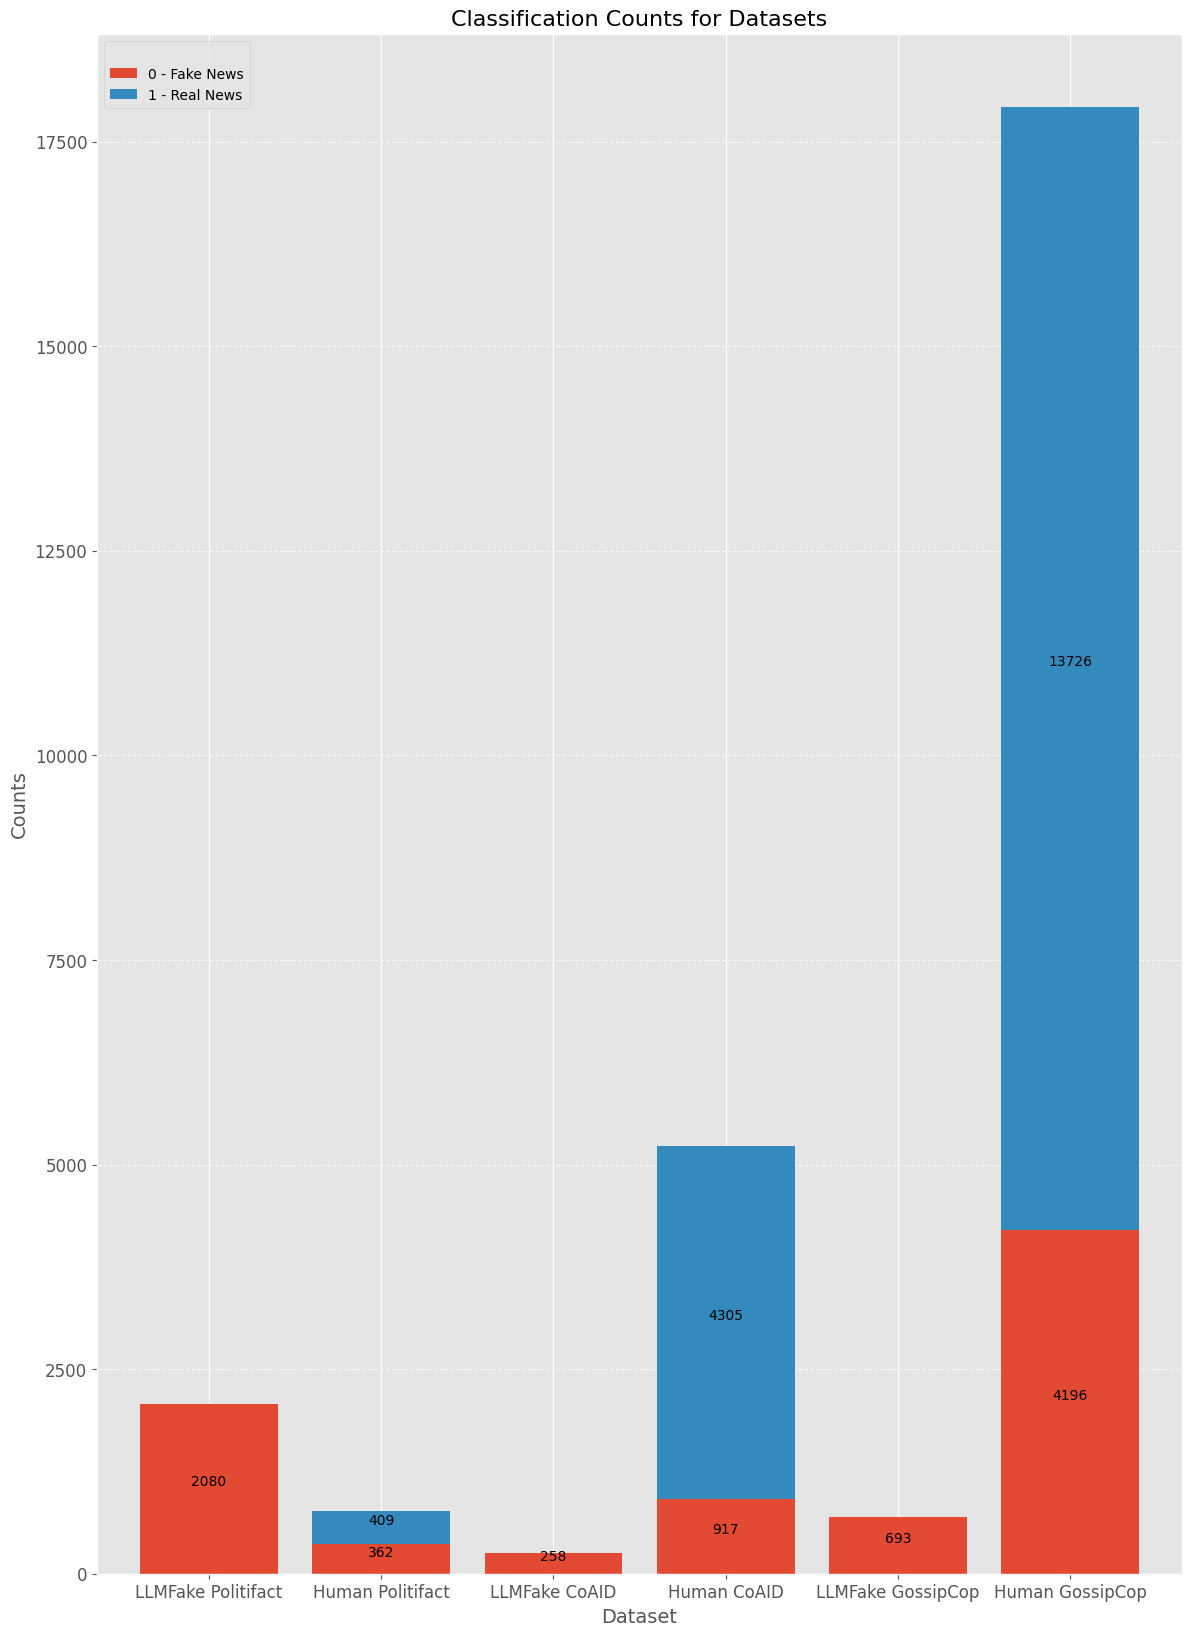

In [23]:
# Plot count data

# Calculate value counts for each DataFrame
is_true_counts_politifact = all_politifact['is_true'].value_counts().sort_index()
is_true_counts_gossipcop = all_gossipcop['is_true'].value_counts().sort_index()
is_true_counts_coaid = all_coaid['is_true'].value_counts().sort_index()
is_true_counts_politifact_new = politifact['is_true'].value_counts().sort_index()
is_true_counts_gossipcop_new = gossipcop['is_true'].value_counts().sort_index()
is_true_counts_coaid_new = coaid['is_true'].value_counts().sort_index()

# Combine the counts into a DataFrame for easier plotting
combined_counts_df = pd.DataFrame({
    'LLMFake Politifact': is_true_counts_politifact,
    'Human Politifact': is_true_counts_politifact_new,
    'LLMFake CoAID': is_true_counts_coaid,
    'Human CoAID': is_true_counts_coaid_new,
    'LLMFake GossipCop': is_true_counts_gossipcop,
    'Human GossipCop': is_true_counts_gossipcop_new
}).transpose()

# Fill NaN values with 0
combined_counts_df.fillna(0, inplace=True)

# Custom order with gaps
order = [
    'LLMFake Politifact', 'Human Politifact', '', 
    'LLMFake CoAID', 'Human CoAID', '', 
    'LLMFake GossipCop', 'Human GossipCop'
]
# Adjust the order and insert gaps
new_index = pd.Index(order)
combined_counts_df = combined_counts_df.reindex(new_index)
combined_counts_df.drop('', inplace=True) 

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14, 20))
combined_counts_df.plot(kind='bar', ax=ax, stacked=True, width=0.8)
plt.title('Classification Counts for Datasets', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value labels for each segment in the stacked bar
for bar in ax.patches:
    height = int(bar.get_height())
    if height > 0:
        ax.annotate(f'{height}',
                    (bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.legend(title=' ', labels=['0 - Fake News', '1 - Real News'])
plt.show()


In [10]:
# Check no remaining duplicates or missing rows
total_missing = all_politifact.isnull().sum().sum()
total_duplicates = all_politifact.duplicated().sum()
print(total_missing, total_duplicates)

total_missing = all_gossipcop.isnull().sum().sum()
total_duplicates = all_gossipcop.duplicated().sum()
print(total_missing, total_duplicates)

total_missing = all_coaid.isnull().sum().sum()
total_duplicates = all_gossipcop.duplicated().sum()
print(total_missing, total_duplicates)

total_missing = politifact.isnull().sum().sum()
total_duplicates = politifact.duplicated().sum()
print(total_missing, total_duplicates)

total_missing = gossipcop.isnull().sum().sum()
total_duplicates = gossipcop.duplicated().sum()
print(total_missing, total_duplicates)

total_missing = coaid.isnull().sum().sum()
total_duplicates = gossipcop.duplicated().sum()
print(total_missing, total_duplicates)

0 0
0 0
0 0
0 0
0 0
0 0


/var/folders/dy/5p_bn1m946x3s0bhx_9_t6b80000gn/T/ipykernel_35309/186501927.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dataset', y='word_count', data=combined_df, palette=palette)


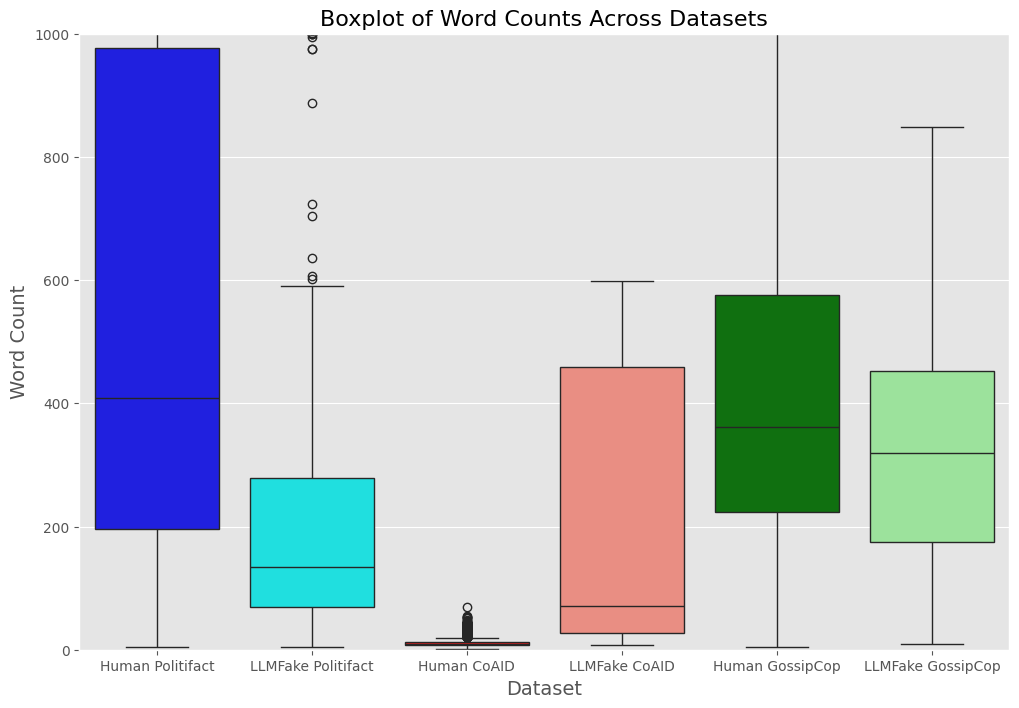

In [22]:
# Plot word count distributions
politifact['word_count'] = politifact['text'].str.split().str.len()
gossipcop['word_count'] = gossipcop['text'].str.split().str.len()
coaid['word_count'] = coaid['text'].str.split().str.len()
all_politifact['word_count'] = all_politifact['text'].str.split().str.len()
all_gossipcop['word_count'] = all_gossipcop['text'].str.split().str.len()
all_coaid['word_count'] = all_coaid['text'].str.split().str.len()

combined_df = pd.DataFrame({
    'word_count': pd.concat([
        politifact['word_count'], 
        all_politifact['word_count'], 
        coaid['word_count'], 
        all_coaid['word_count'], 
        gossipcop['word_count'], 
        all_gossipcop['word_count']
    ]),
    'dataset': (
        ['Human Politifact'] * len(politifact) + 
        ['LLMFake Politifact'] * len(all_politifact) + 
        ['Human CoAID'] * len(coaid) + 
        ['LLMFake CoAID'] * len(all_coaid) + 
        ['Human GossipCop'] * len(gossipcop) + 
        ['LLMFake GossipCop'] * len(all_gossipcop)
    )
})

# Set up the figure
plt.figure(figsize=(12, 8))

palette = {
    'Human Politifact': 'blue',
    'LLMFake Politifact': 'cyan',
    'Human CoAID': 'red',
    'LLMFake CoAID': 'salmon',
    'Human GossipCop': 'green',
    'LLMFake GossipCop': 'lightgreen'
}

sns.boxplot(x='dataset', y='word_count', data=combined_df, palette=palette)

# Add labels and title
plt.title('Boxplot of Word Counts Across Datasets', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Word Count', fontsize=14)
plt.ylim(0, 1000)
plt.show()
